<a href="https://colab.research.google.com/github/jjefferson2006/DSWP_JJ_altera/blob/main/desafio_analise_5_ordenado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install pycaret

In [58]:
from pycaret.classification import *

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix

In [118]:
#função pro cross_val
def funcao_cross_val_score(modelo, X_treinamento, y_treinamento, CV):
    # versão com sklearn.model_selection.cross_validate:
    #a_scores_CV = cross_validate(modelo, X_treinamento, y_treinamento, cv = CV, scoring = metodo)
    #print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    #print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    #return a_scores_CV

    #versão com cross_val_score::
    a_scores_CV = cross_val_score(modelo, X_treinamento, y_treinamento, cv = CV)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    return a_scores_CV

In [119]:
#grid para cV
def GridSearchOptimizer(modelo, ml_Opt, d_hiperparametros, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas):
    ml_GridSearchCV = GridSearchCV(modelo, d_hiperparametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_treinamento, y_treinamento)
    tempo_elapsed = time()-start
    print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Hiperparâmetros que otimizam a classificação:
    print(f'\nHiperparâmetros otimizados: {ml_GridSearchCV.best_params_}')
    
    if ml_Opt == 'ml_DT2':
        print(f'\nDecisionTreeClassifier *********************************************************************************************************')
        ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_RF2':
        print(f'\nRandomForestClassifier *********************************************************************************************************')
        ml_Opt = RandomForestClassifier(bootstrap= ml_GridSearchCV.best_params_['bootstrap'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_features= ml_GridSearchCV.best_params_['max_features'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_split'],
                                        n_estimators= ml_GridSearchCV.best_params_['n_estimators'],
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_AB2':
        print(f'\nAdaBoostClassifier *********************************************************************************************************')
        ml_Opt = AdaBoostClassifier(algorithm='SAMME.R', 
                                    base_estimator=RandomForestClassifier(bootstrap = False, 
                                                                          max_depth = 10, 
                                                                          max_features = 'auto', 
                                                                          min_samples_leaf = 1, 
                                                                          min_samples_split = 2, 
                                                                          n_estimators = 400), 
                                    learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                    n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                    random_state = i_Seed)
        
    elif ml_Opt == 'ml_GB2':
        print(f'\nGradientBoostingClassifier *********************************************************************************************************')
        ml_Opt = GradientBoostingClassifier(learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                            n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                            max_depth = ml_GridSearchCV.best_params_['max_depth'], 
                                            min_samples_split = ml_GridSearchCV.best_params_['min_samples_split'], 
                                            min_samples_leaf = ml_GridSearchCV.best_params_['min_samples_leaf'], 
                                            max_features = ml_GridSearchCV.best_params_['max_features'])
        
    elif ml_Opt == 'ml_XGB2':
        print(f'\nXGBoostingClassifier *********************************************************************************************************')
        ml_Opt = XGBoostingClassifier(learning_rate= ml_GridSearchCV.best_params_['learning_rate'], 
                                      max_depth= ml_GridSearchCV.best_params_['max_depth'], 
                                      colsample_bytree= ml_GridSearchCV.best_params_['colsample_bytree'], 
                                      subsample= ml_GridSearchCV.best_params_['subsample'], 
                                      gamma= ml_GridSearchCV.best_params_['gamma'], 
                                      min_child_weight= ml_GridSearchCV.best_params_['min_child_weight'])
        
    # Treina novamente usando os hiperparâmetros otimizados...
    ml_Opt.fit(X_treinamento, y_treinamento)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    a_scores_CV = funcao_cross_val_score(ml_Opt, X_treinamento, y_treinamento, i_CV)

    # Faz predições com os hiperparâmetros otimizados...
    y_pred = ml_Opt.predict(X_teste)
  
    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(l_colunas, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_teste, y_pred)
    cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
    cf_categories = ['Zero', 'One']
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

In [120]:
#coluna relevantes
from sklearn.feature_selection import SelectFromModel

def seleciona_colunas_relevantes(modelo, X_treinamento, X_teste, threshold = 0.05):
    # Cria um seletor para selecionar as COLUNAS com importância > threshold
    sfm = SelectFromModel(modelo, threshold)
    
    # Treina o seletor
    sfm.fit(X_treinamento, y_treinamento)

    # Mostra o indice das COLUNAS mais importantes
    print(f'\n********** COLUNAS Relevantes ******')
    print(sfm.get_support(indices=True))

    # Seleciona somente as COLUNAS relevantes
    X_treinamento_I = sfm.transform(X_treinamento)
    X_teste_I = sfm.transform(X_teste)
    return X_treinamento_I, X_teste_I   

In [121]:
#mostra colunas relevantes
def mostra_feature_importances(clf, X_treinamento, y_treinamento=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_treinamento and y_treinamento are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_treinamento     (pandas DataFrame)
        
        y_treinamento     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "mostra_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    from xgboost.core     import XGBoostError
    from lightgbm.sklearn import LightGBMError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_treinamento.values, y_treinamento.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, LightGBMError, ValueError):
        clf.fit(X_treinamento.values, y_treinamento.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_treinamento.columns
    feat_imp.sort_values(by ='importance', ascending = False, inplace = True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace = True)
    feat_imp = feat_imp.set_index('feature', drop = True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by = 'importance', ascending = False))
        
    return feat_imp

In [123]:
from sklearn.metrics import accuracy_score # para medir a acurácia do modelo preditivo
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix # para plotar a confusion matrix

from sklearn.model_selection import GridSearchCV # para otimizar os parâmetros dos modelos preditivos
from sklearn.model_selection import cross_val_score # Para o CV (Cross-Validation)
from sklearn.model_selection import cross_validate

from time import time
from operator import itemgetter
from scipy.stats import randint

from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

np.set_printoptions(suppress=True)

###carrega o train

In [60]:
url = 'https://raw.githubusercontent.com/jjefferson2006/DSWP_JJ_altera/main/train.csv'
df_churn_train = pd.read_csv(url)
df_churn_train

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,6684,Male,0,No,No,43.0,No,No phone service,DSL,No,No,Yes,Yes,No,Yes,One year,No,Electronic check,44.15,1931.3,0
5630,604,Male,0,No,No,NaN,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,No,Electronic check,108.65,4903.2,0
5631,4803,Female,0,No,No,28.0,Yes,No,DSL,No,Yes,No,Yes,No,No,Month-to-month,No,Bank transfer (automatic),54.65,1517.5,0
5632,6317,Male,0,Yes,Yes,63.0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.25,1573.05,0


In [61]:
#Normalizar as colunas
df_churn_train.columns = [col.lower() for col in df_churn_train.columns]
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [62]:
df_churn_train.dtypes

id                    int64
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure              float64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                 int64
dtype: object

In [63]:
df_churn_train.isna().sum()

id                    0
gender                0
seniorcitizen         0
partner               0
dependents          218
tenure              461
phoneservice          0
multiplelines         0
internetservice       0
onlinesecurity        0
onlinebackup          0
deviceprotection      0
techsupport           0
streamingtv           0
streamingmovies       0
contract              0
paperlessbilling      0
paymentmethod        99
monthlycharges        0
totalcharges          0
churn                 0
dtype: int64

In [8]:
df_churn_train.shape

(5634, 21)

###train: pay depent

In [64]:
df_churn_train['paymentmethod'].fillna('Electronic check', inplace=True)
df_churn_train['dependents'].fillna('No', inplace=True)

In [65]:
df_churn_train['totalcharges'] = df_churn_train['totalcharges'].str.replace(',', '.')
df_churn_train['totalcharges'] = pd.to_numeric(df_churn_train['totalcharges'], errors= 'coerce')


In [66]:
df_churn_train['tenure_esti']=round(df_churn_train['totalcharges']/df_churn_train['monthlycharges'],2)


In [67]:
df_churn_train['tenure_rou']=round(df_churn_train['tenure_esti'])

In [68]:
l_tot_ten = list(df_churn_train[df_churn_train['tenure'].isna()].index)
for i in l_tot_ten:
    df_churn_train['tenure'][i] = df_churn_train['tenure_rou'][i]


In [69]:
df_churn_train.drop(columns=['tenure_esti','tenure_rou'], inplace=True)

In [70]:
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Electronic check,45.05,2560.10,0
1,6731,Male,0,Yes,Yes,17.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.70,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.80,1


In [71]:
df_churn_train.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        8
churn               0
dtype: int64

In [72]:
l_charg = list(df_churn_train[df_churn_train['totalcharges'].isna()].index)
l_charg

[161, 416, 1766, 2145, 3375, 3404, 4008, 5151]

In [73]:
for i in l_charg:
    df_churn_train['totalcharges'][i] = 0.0

In [74]:
df_churn_train.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

###Train: poe  'no phone service' em no e no internet service no no

In [75]:
df_churn_train.onlinesecurity.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.multiplelines.replace(['No phone service'], ['No'], inplace=True)
df_churn_train.onlinebackup.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.deviceprotection.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.techsupport.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.streamingtv.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.streamingmovies.replace(['No internet service'], ['No'], inplace=True)

In [76]:
df_churn_train.gender.replace(['Female', 'Male'], [1, 0], inplace=True)
df_churn_train.partner.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_train.dependents.replace(['Yes', 'No'], [1, 0], inplace=True)


In [77]:
df_churn_train.multiplelines.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_train.onlinesecurity.replace(['No', 'Yes'], [0,1], inplace=True) 
df_churn_train.onlinebackup.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_train.deviceprotection.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_train.techsupport.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_train.streamingtv.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_train.streamingmovies.replace(['No', 'Yes'], [0,1], inplace=True)

In [78]:
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4030,1,0,0,0,56.0,No,0,DSL,1,1,1,1,0,0,Two year,No,Electronic check,45.05,2560.10,0
1,6731,0,0,1,1,17.0,Yes,0,No,0,0,0,0,0,0,One year,No,Mailed check,19.65,332.65,0
2,6479,1,0,1,0,60.0,Yes,1,Fiber optic,0,1,1,1,1,1,Two year,Yes,Credit card (automatic),110.80,6640.70,0
3,6861,1,0,0,0,37.0,Yes,1,Fiber optic,0,1,1,0,1,1,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,0,0,1,1,29.0,Yes,0,Fiber optic,0,0,0,0,0,0,Month-to-month,Yes,Electronic check,70.75,1974.80,1


In [79]:
dummy_tr=pd.get_dummies(df_churn_train[['phoneservice','internetservice','contract','paperlessbilling','paymentmethod']])
dummy_tr

,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,1,0,1,0,0,0,0,1,1,0,0,0,1,0
1,0,1,0,0,1,0,1,0,1,0,0,0,0,1
2,0,1,0,1,0,0,0,1,0,1,0,1,0,0
3,0,1,0,1,0,1,0,0,0,1,1,0,0,0
4,0,1,0,1,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,1,0,1,0,0,0,1,0,1,0,0,0,1,0
5630,0,1,0,1,0,0,0,1,1,0,0,0,1,0
5631,0,1,1,0,0,1,0,0,1,0,1,0,0,0
5632,0,1,0,0,1,0,0,1,1,0,0,0,0,1


In [80]:
df_train_dumy=pd.concat([df_churn_train,dummy_tr],axis=1)
df_train_dumy

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,4030,1,0,0,0,56.0,No,0,DSL,1,1,1,1,0,0,Two year,No,Electronic check,45.05,2560.10,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0
1,6731,0,0,1,1,17.0,Yes,0,No,0,0,0,0,0,0,One year,No,Mailed check,19.65,332.65,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1
2,6479,1,0,1,0,60.0,Yes,1,Fiber optic,0,1,1,1,1,1,Two year,Yes,Credit card (automatic),110.80,6640.70,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0
3,6861,1,0,0,0,37.0,Yes,1,Fiber optic,0,1,1,0,1,1,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0
4,3266,0,0,1,1,29.0,Yes,0,Fiber optic,0,0,0,0,0,0,Month-to-month,Yes,Electronic check,70.75,1974.80,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,6684,0,0,0,0,43.0,No,0,DSL,0,0,1,1,0,1,One year,No,Electronic check,44.15,1931.30,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0
5630,604,0,0,0,0,45.0,Yes,1,Fiber optic,0,1,1,1,1,1,Two year,No,Electronic check,108.65,4903.20,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0
5631,4803,1,0,0,0,28.0,Yes,0,DSL,0,1,0,1,0,0,Month-to-month,No,Bank transfer (automatic),54.65,1517.50,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0
5632,6317,0,0,1,1,63.0,Yes,1,No,0,0,0,0,0,0,Two year,No,Mailed check,25.25,1573.05,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1


In [81]:
df_train_dumy.drop(columns=['phoneservice','internetservice','contract','paperlessbilling','paymentmethod'], inplace = True)

In [82]:
df_train_dumy.isna().sum()

id                                         0
gender                                     0
seniorcitizen                              0
partner                                    0
dependents                                 0
tenure                                     0
multiplelines                              0
onlinesecurity                             0
onlinebackup                               0
deviceprotection                           0
techsupport                                0
streamingtv                                0
streamingmovies                            0
monthlycharges                             0
totalcharges                               0
churn                                      0
phoneservice_No                            0
phoneservice_Yes                           0
internetservice_DSL                        0
internetservice_Fiber optic                0
internetservice_No                         0
contract_Month-to-month                    0
contract_O

In [83]:
df_train_dumy.head()

,id,gender,seniorcitizen,partner,dependents,tenure,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,monthlycharges,totalcharges,churn,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,4030,1,0,0,0,56.0,0,1,1,1,1,0,0,45.05,2560.10,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0
1,6731,0,0,1,1,17.0,0,0,0,0,0,0,0,19.65,332.65,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1
2,6479,1,0,1,0,60.0,1,0,1,1,1,1,1,110.80,6640.70,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0
3,6861,1,0,0,0,37.0,1,0,1,1,0,1,1,101.90,3545.35,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0
4,3266,0,0,1,1,29.0,0,0,0,0,0,0,0,70.75,1974.80,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0


###TESTE:carrerga o teste

In [84]:
url = 'https://raw.githubusercontent.com/jjefferson2006/DSWP_JJ_altera/main/test.csv'
df_churn_test = pd.read_csv(url)
df_churn_test

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5027,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.3
1,1733,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,NaN,99.00,5969.3
2,5384,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,6554,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,364,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,4897,Male,0,No,NaN,24.0,Yes,No,DSL,No,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,49.70,1167.8
1405,6940,Male,0,No,No,35.0,Yes,No,Fiber optic,Yes,No,No,Yes,No,Yes,One year,Yes,Electronic check,89.20,3251.3
1406,804,Female,0,Yes,No,46.0,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Two year,Yes,Credit card (automatic),64.20,3009.5
1407,1143,Male,1,Yes,Yes,11.0,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.20,775.3


In [85]:
#Normalizar as colunas
df_churn_test.columns = [col.lower() for col in df_churn_test.columns]
df_churn_test.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,5027,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.3
1,1733,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,NaN,99.00,5969.3
2,5384,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,6554,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,364,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.7


In [86]:
df_churn_test.dtypes

id                    int64
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure              float64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
dtype: object

In [87]:
df_churn_test.isna().sum()

id                    0
gender                0
seniorcitizen         0
partner               0
dependents           41
tenure              118
phoneservice          0
multiplelines         0
internetservice       0
onlinesecurity        0
onlinebackup          0
deviceprotection      0
techsupport           0
streamingtv           0
streamingmovies       0
contract              0
paperlessbilling      0
paymentmethod        30
monthlycharges        0
totalcharges          0
dtype: int64

In [88]:
df_churn_test.shape

(1409, 20)

#TESTE:tratamento do dependentes/ paymenthod /total / tenure

In [89]:
df_churn_test['dependents'].fillna('No', inplace=True)
df_churn_test['paymentmethod'].fillna('Electronic check', inplace=True)

In [90]:
df_churn_test['totalcharges'] = df_churn_test['totalcharges'].str.replace(',', '.')
df_churn_test['totalcharges'] = pd.to_numeric(df_churn_test['totalcharges'], errors= 'coerce')
df_churn_test[['totalcharges']].isna().sum()

totalcharges    3
dtype: int64

In [91]:
df_churn_test['tenure_esti']=round(df_churn_test['totalcharges']/df_churn_test['monthlycharges'],2)
df_churn_test['tenure_rou']=round(df_churn_test['tenure_esti'])
l_tot_ten = list(df_churn_test[df_churn_test['tenure'].isna()].index)
for i in l_tot_ten:
    df_churn_test['tenure'][i] = df_churn_test['tenure_rou'][i]


In [92]:
l_index_charg = list(df_churn_test[df_churn_test['totalcharges'].isna()].index)
l_index_charg

[313, 1063, 1297]

In [93]:
df_churn_test[['tenure','totalcharges']][313:314]

,tenure,totalcharges
313,0.0,NaN


In [94]:
df_churn_test.drop(columns=['tenure_esti','tenure_rou'], inplace=True)

In [95]:
for i in l_index_charg:
    df_churn_test['totalcharges'][i] = 0.0

In [96]:
df_churn_test.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

###TESTE: poe  'no phone service' em no e no internet service no no

In [97]:
df_churn_test.onlinesecurity.replace(['No internet service'],['No'],inplace=True)
df_churn_test.multiplelines.replace(['No phone service'],['No'],inplace=True)
df_churn_test.onlinebackup.replace(['No internet service'],['No'],inplace=True)
df_churn_test.deviceprotection.replace(['No internet service'],['No'],inplace=True)
df_churn_test.techsupport.replace(['No internet service'],['No'],inplace=True)
df_churn_test.streamingtv.replace(['No internet service'],['No'],inplace=True)
df_churn_test.streamingmovies.replace(['No internet service'],['No'],inplace=True)

In [98]:
df_churn_test.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,5027,Male,0,Yes,Yes,23.0,Yes,No,No,No,No,No,No,No,No,One year,Yes,Credit card (automatic),20.00,445.30
1,1733,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,Electronic check,99.00,5969.30
2,5384,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,6554,Female,0,Yes,Yes,61.0,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,364,Female,0,No,No,47.0,Yes,No,No,No,No,No,No,No,No,Two year,Yes,Mailed check,20.55,945.70


In [99]:
df_churn_test.gender.replace(['Female', 'Male'], [1, 0], inplace=True)
df_churn_test.partner.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_test.dependents.replace(['Yes', 'No'], [1, 0], inplace=True)


In [100]:
df_churn_test.multiplelines.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_test.onlinesecurity.replace(['No', 'Yes'], [0,1], inplace=True) 
df_churn_test.onlinebackup.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_test.deviceprotection.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_test.techsupport.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_test.streamingtv.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_test.streamingmovies.replace(['No', 'Yes'], [0,1], inplace=True)

In [101]:
dummy_t=pd.get_dummies(df_churn_test[['phoneservice','internetservice','contract','paperlessbilling','paymentmethod']])
dummy_t

,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
1,0,1,0,1,0,0,1,0,1,0,0,0,1,0
2,0,1,0,1,0,1,0,0,0,1,0,0,1,0
3,1,0,1,0,0,0,0,1,0,1,1,0,0,0
4,0,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0,1,1,0,0,1,0,0,0,1,0,0,0,1
1405,0,1,0,1,0,0,1,0,0,1,0,0,1,0
1406,0,1,1,0,0,0,0,1,0,1,0,1,0,0
1407,0,1,0,1,0,1,0,0,0,1,0,1,0,0


In [102]:
df_test_dumy=pd.concat([df_churn_test,dummy_t],axis=1)
df_test_dumy

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,5027,0,0,1,1,23.0,Yes,0,No,0,0,0,0,0,0,One year,Yes,Credit card (automatic),20.00,445.30,0,1,0,0,1,0,1,0,0,1,0,1,0,0
1,1733,0,1,1,1,61.0,Yes,1,Fiber optic,0,1,0,0,1,1,One year,No,Electronic check,99.00,5969.30,0,1,0,1,0,0,1,0,1,0,0,0,1,0
2,5384,0,0,0,0,36.0,Yes,1,Fiber optic,0,0,0,0,0,1,Month-to-month,Yes,Electronic check,84.75,3050.15,0,1,0,1,0,1,0,0,0,1,0,0,1,0
3,6554,1,0,1,1,61.0,No,0,DSL,0,1,1,1,1,1,Two year,Yes,Bank transfer (automatic),61.45,3751.15,1,0,1,0,0,0,0,1,0,1,1,0,0,0
4,364,1,0,0,0,47.0,Yes,0,No,0,0,0,0,0,0,Two year,Yes,Mailed check,20.55,945.70,0,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,4897,0,0,0,0,24.0,Yes,0,DSL,0,0,1,0,0,0,Month-to-month,Yes,Mailed check,49.70,1167.80,0,1,1,0,0,1,0,0,0,1,0,0,0,1
1405,6940,0,0,0,0,35.0,Yes,0,Fiber optic,1,0,0,1,0,1,One year,Yes,Electronic check,89.20,3251.30,0,1,0,1,0,0,1,0,0,1,0,0,1,0
1406,804,1,0,1,0,46.0,Yes,0,DSL,0,1,0,1,1,0,Two year,Yes,Credit card (automatic),64.20,3009.50,0,1,1,0,0,0,0,1,0,1,0,1,0,0
1407,1143,0,1,1,1,11.0,Yes,1,Fiber optic,0,0,0,0,0,0,Month-to-month,Yes,Credit card (automatic),75.20,775.30,0,1,0,1,0,1,0,0,0,1,0,1,0,0


In [103]:
df_test_dumy.drop(columns=['phoneservice','internetservice','contract','paperlessbilling','paymentmethod'], inplace = True)

In [104]:
df_test_dumy.isna().sum()

id                                         0
gender                                     0
seniorcitizen                              0
partner                                    0
dependents                                 0
tenure                                     0
multiplelines                              0
onlinesecurity                             0
onlinebackup                               0
deviceprotection                           0
techsupport                                0
streamingtv                                0
streamingmovies                            0
monthlycharges                             0
totalcharges                               0
phoneservice_No                            0
phoneservice_Yes                           0
internetservice_DSL                        0
internetservice_Fiber optic                0
internetservice_No                         0
contract_Month-to-month                    0
contract_One year                          0
contract_T

In [105]:
df_test_dumy.head()

,id,gender,seniorcitizen,partner,dependents,tenure,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,monthlycharges,totalcharges,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,5027,0,0,1,1,23.0,0,0,0,0,0,0,0,20.00,445.30,0,1,0,0,1,0,1,0,0,1,0,1,0,0
1,1733,0,1,1,1,61.0,1,0,1,0,0,1,1,99.00,5969.30,0,1,0,1,0,0,1,0,1,0,0,0,1,0
2,5384,0,0,0,0,36.0,1,0,0,0,0,0,1,84.75,3050.15,0,1,0,1,0,1,0,0,0,1,0,0,1,0
3,6554,1,0,1,1,61.0,0,0,1,1,1,1,1,61.45,3751.15,1,0,1,0,0,0,0,1,0,1,1,0,0,0
4,364,1,0,0,0,47.0,0,0,0,0,0,0,0,20.55,945.70,0,1,0,0,1,0,0,1,0,1,0,0,0,1


###AUTO ML

In [106]:
df_train_dumy.columns

Index(['id', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'monthlycharges',
       'totalcharges', 'churn', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [107]:
clf = setup(data = df_train_dumy,
            target = 'churn',
            #numeric_features = ['tenure', 'monthlycharges', 'totalcharges'] 
            #numeric_imputation = 'mean'
            categorical_features = ['gender', 'seniorcitizen', 'partner', 'dependents', 
                                    'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
                                    'techsupport', 'streamingtv', 'streamingmovies', 'phoneservice_No', 'phoneservice_Yes',
                                    'internetservice_DSL', 'internetservice_Fiber optic',
                                    'internetservice_No', 'contract_Month-to-month', 'contract_One year',
                                    'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
                                    'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)',
                                    'paymentmethod_Electronic check', 'paymentmethod_Mailed check'], # lista das variáveis categóricas
            ignore_features = ['id'], 
            silent = False)

,Description,Value
0,session_id,8218
1,Target,churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5634, 30)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,25
8,Ordinal Features,False
9,High Cardinality Features,False


In [108]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8062,0.8517,0.5462,0.6742,0.6028,0.4767,0.4817,0.447
lr,Logistic Regression,0.8057,0.8484,0.5734,0.6625,0.6144,0.4855,0.4880,0.379
catboost,CatBoost Classifier,0.8009,0.8424,0.5292,0.6659,0.5885,0.4597,0.4657,3.293
ada,Ada Boost Classifier,0.8007,0.8472,0.5509,0.6557,0.5981,0.4671,0.4706,0.211
ridge,Ridge Classifier,0.7996,0.0000,0.5320,0.6601,0.5890,0.4585,0.4633,0.026
lda,Linear Discriminant Analysis,0.7971,0.8410,0.5686,0.6400,0.6021,0.4666,0.4682,0.038
rf,Random Forest Classifier,0.7930,0.8267,0.5151,0.6475,0.5727,0.4387,0.4443,0.715
lightgbm,Light Gradient Boosting Machine,0.7923,0.8318,0.5451,0.6344,0.5857,0.4483,0.4510,0.121
et,Extra Trees Classifier,0.7768,0.8046,0.4944,0.6080,0.5439,0.3985,0.4031,0.678
xgboost,Extreme Gradient Boosting,0.7755,0.8159,0.5094,0.5993,0.5494,0.4016,0.4047,0.752


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8218, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [109]:
gbc = create_model('gbc') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8101,0.8769,0.5234,0.7000,0.5989,0.4779,0.4866
1,0.7848,0.8259,0.5047,0.6279,0.5596,0.4194,0.4238
2,0.8025,0.8468,0.5234,0.6747,0.5895,0.4622,0.4687
3,0.8020,0.8462,0.5234,0.6747,0.5895,0.4618,0.4682
4,0.8147,0.8340,0.6038,0.6737,0.6368,0.5130,0.5143
5,0.7919,0.8430,0.5094,0.6429,0.5684,0.4337,0.4388
6,0.7995,0.8575,0.5094,0.6667,0.5775,0.4492,0.4561
7,0.8274,0.8845,0.5849,0.7209,0.6458,0.5334,0.5385
8,0.8173,0.8528,0.5660,0.6977,0.6250,0.5059,0.5108
9,0.8122,0.8495,0.6132,0.6633,0.6373,0.5108,0.5115


In [110]:
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8152,0.8771,0.5421,0.7073,0.6138,0.4951,0.5026
1,0.7873,0.8237,0.4953,0.6386,0.5579,0.4208,0.4267
2,0.8152,0.8477,0.5140,0.7237,0.6011,0.4853,0.4973
3,0.8046,0.8459,0.5234,0.6829,0.5926,0.4670,0.4741
4,0.7995,0.8378,0.5755,0.6421,0.6070,0.4729,0.4742
5,0.7970,0.8445,0.5377,0.6477,0.5876,0.4545,0.4579
6,0.7995,0.8569,0.4906,0.6753,0.5683,0.4420,0.4515
7,0.8426,0.8815,0.6132,0.7558,0.6771,0.5745,0.5800
8,0.8122,0.8475,0.5849,0.6739,0.6263,0.5017,0.5039
9,0.8147,0.8553,0.6132,0.6701,0.6404,0.5159,0.5169


In [114]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8203,0.8638,0.5794,0.7045,0.6359,0.5181,0.5224
1,0.7747,0.8188,0.5234,0.5957,0.5572,0.4070,0.4085
2,0.8025,0.8434,0.5514,0.6629,0.6020,0.4722,0.4757
3,0.7843,0.8367,0.5514,0.6146,0.5813,0.4366,0.4377
4,0.7843,0.8261,0.5472,0.6105,0.5771,0.4329,0.4341
5,0.8096,0.8487,0.5755,0.6703,0.6193,0.4934,0.4959
6,0.8147,0.8581,0.5566,0.6941,0.6178,0.4975,0.5027
7,0.8274,0.8771,0.6038,0.7111,0.6531,0.5392,0.5424
8,0.8173,0.8437,0.6321,0.6700,0.6505,0.5269,0.5273
9,0.8223,0.8673,0.6132,0.6915,0.6500,0.5315,0.5332


In [115]:
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8177,0.8634,0.5794,0.6966,0.6327,0.5128,0.5166
1,0.7772,0.8192,0.5327,0.6000,0.5644,0.4154,0.4167
2,0.8177,0.8449,0.5888,0.6923,0.6364,0.5158,0.5188
3,0.7716,0.8320,0.5047,0.5934,0.5455,0.3942,0.3965
4,0.7843,0.8259,0.5472,0.6105,0.5771,0.4329,0.4341
5,0.8096,0.8490,0.5755,0.6703,0.6193,0.4934,0.4959
6,0.8147,0.8581,0.5566,0.6941,0.6178,0.4975,0.5027
7,0.8274,0.8789,0.6132,0.7065,0.6566,0.5421,0.5445
8,0.8173,0.8386,0.6038,0.6809,0.6400,0.5181,0.5198
9,0.8223,0.8672,0.6132,0.6915,0.6500,0.5315,0.5332


In [116]:
predic = predict_model(tuned_lr, data = df_test_dumy)
predic

,gender,seniorcitizen,partner,dependents,tenure,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,monthlycharges,totalcharges,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,Label,Score
0,0,0,1,1,23.0,0,0,0,0,0,0,0,20.00,445.30,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0.9593
1,0,1,1,1,61.0,1,0,1,0,0,1,1,99.00,5969.30,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0.8511
2,0,0,0,0,36.0,1,0,0,0,0,0,1,84.75,3050.15,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0.5015
3,1,0,1,1,61.0,0,0,1,1,1,1,1,61.45,3751.15,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0.9624
4,1,0,0,0,47.0,0,0,0,0,0,0,0,20.55,945.70,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0.9908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0,0,0,0,24.0,0,0,0,1,0,0,0,49.70,1167.80,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0.7684
1405,0,0,0,0,35.0,0,1,0,0,1,0,1,89.20,3251.30,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0.8439
1406,1,0,1,0,46.0,0,0,1,0,1,1,0,64.20,3009.50,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0.9636
1407,0,1,1,1,11.0,1,0,0,0,0,0,0,75.20,775.30,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0.6046


In [117]:
predic['Score'].mean()

0.7978953158268279

In [ ]:
predic['Score'].std()

In [112]:
'''predic['Score'].mean() gbc

0.8009507452093694

In [113]:
'''predic['Score'].std() gbc

0.1452065453933929

In [ ]:
pred_val = predic['Label']

In [ ]:
from google.colab import files

In [ ]:
ids = df_churn_test['id']
output = pd.DataFrame({'id': ids, 'Churn': pred_val})
output.to_csv('submission37cat.csv', index=False)
files.download('submission37cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###modelos indiciduais

In [124]:
df_train = df_train_dumy.copy()


In [125]:
df_y = df_train['churn']

In [126]:
df_train.drop(columns = 'churn', inplace = True)

In [127]:
df_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,monthlycharges,totalcharges,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,4030,1,0,0,0,56.0,0,1,1,1,1,0,0,45.05,2560.10,1,0,1,0,0,0,0,1,1,0,0,0,1,0
1,6731,0,0,1,1,17.0,0,0,0,0,0,0,0,19.65,332.65,0,1,0,0,1,0,1,0,1,0,0,0,0,1
2,6479,1,0,1,0,60.0,1,0,1,1,1,1,1,110.80,6640.70,0,1,0,1,0,0,0,1,0,1,0,1,0,0
3,6861,1,0,0,0,37.0,1,0,1,1,0,1,1,101.90,3545.35,0,1,0,1,0,1,0,0,0,1,1,0,0,0
4,3266,0,0,1,1,29.0,0,0,0,0,0,0,0,70.75,1974.80,0,1,0,1,0,1,0,0,0,1,0,0,1,0


In [128]:
df_X = df_train

In [129]:
from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_X, df_y, test_size = 0.2)

In [130]:
X_treinamento.head()

,id,gender,seniorcitizen,partner,dependents,tenure,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,monthlycharges,totalcharges,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
3432,887,1,1,0,0,7.0,0,0,0,1,0,1,0,84.35,609.65,0,1,0,1,0,1,0,0,0,1,0,0,1,0
5053,1711,1,0,0,0,5.0,1,0,0,1,1,0,0,82.75,417.75,0,1,0,1,0,1,0,0,0,1,0,0,1,0
3944,6958,0,0,0,0,9.0,0,0,0,0,1,1,0,86.25,770.50,0,1,0,1,0,1,0,0,1,0,0,0,1,0
5534,4520,1,0,1,0,57.0,1,0,1,1,1,1,1,109.40,6252.70,0,1,0,1,0,0,1,0,0,1,1,0,0,0
5530,4701,1,0,0,0,2.0,0,0,0,0,0,0,0,45.85,105.60,0,1,1,0,0,1,0,0,0,1,0,0,0,1


In [131]:
y_treinamento

3432    0
5053    0
3944    0
5534    0
5530    0
       ..
2170    0
3993    0
925     1
5526    0
2213    0
Name: churn, Length: 4507, dtype: int64

In [132]:
from sklearn.ensemble import GradientBoostingClassifier

# Instancia...
ml_GB = GradientBoostingClassifier(n_estimators = 100, min_samples_split = 2)

# Treina... 
ml_GB.fit(X_treinamento, y_treinamento)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [133]:
i_CV = 10

In [134]:
# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_GB, X_treinamento, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 80.94
std médio das Acurácias calculadas pelo CV: 1.08


In [135]:
print(f'Acurácias: {a_scores_CV}')

Acurácias: [0.81818182 0.81596452 0.79157428 0.81152993 0.80487805 0.78935698
 0.80709534 0.81555556 0.82444444 0.81555556]


In [136]:
# Faz precições...
y_pred = ml_GB.predict(X_teste)

In [137]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [139]:
def mostra_confusion_matrix(cf, 
                            group_names = None, 
                            categories = 'auto', 
                            count = True, 
                            percent = True, 
                            cbar = True, 
                            xyticks = False, 
                            xyplotlabels = True, 
                            sum_stats = True, 
                            figsize = (8, 8), 
                            cmap = 'Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

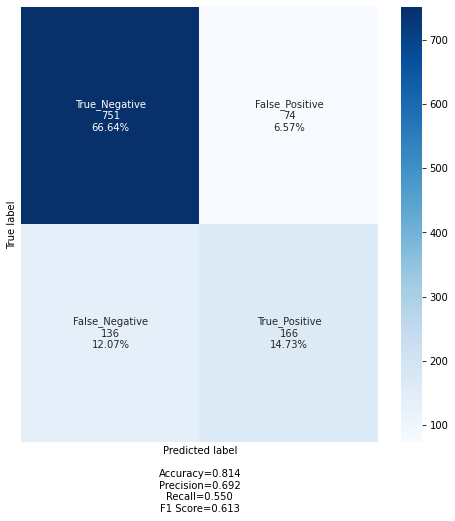

In [140]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative','False_Positive','False_Negative','True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

In [142]:
l_colunas = X_treinamento.columns

In [143]:
# Dicionário de parâmetros para o parameter tunning.
d_hiperparametros_GB= {'learning_rate': [0.4, 0.5],
                  'n_estimators': [90, 100],
                  'max_depth': [20, 25],
                  'min_samples_split': [0.2, 0.3],
                  'min_samples_leaf': [0.2, 0.3],
                  'max_features': list(range(1, X_treinamento.shape[1]))}

Fitting 10 folds for each of 896 candidates, totalling 8960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   


GridSearchCV levou 4048.90 segundos.

Hiperparâmetros otimizados: {'learning_rate': 0.5, 'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 0.2, 'min_samples_split': 0.3, 'n_estimators': 100}

GradientBoostingClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 80.5
std médio das Acurácias calculadas pelo CV: 1.43

********* IMPORTÂNCIA DAS COLUNAS ***********
                                     coluna  importancia
20                  contract_Month-to-month     0.290467
27           paymentmethod_Electronic check     0.161140
5                                    tenure     0.155545
13                           monthlycharges     0.082531
7                            onlinesecurity     0.073245
4                                dependents     0.040899
14                             totalcharges     0.040020
19                       in

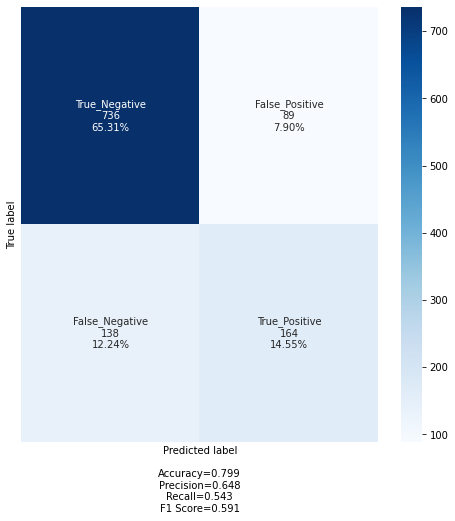

In [144]:
# Invoca a função
ml_GB2, best_params= GridSearchOptimizer(ml_GB, 'ml_GB2', d_hiperparametros_GB, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)

In [145]:
best_params

{'learning_rate': 0.5,
 'max_depth': 20,
 'max_features': 5,
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.3,
 'n_estimators': 100}

In [146]:
# Como o procedimento acima levou 93 minutos para executar, então vou estimar ml_GB2 abaixo usando os parâmetros acima estimados
best_params= {'learning_rate': 0.5, 'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 0.2, 'min_samples_split': 0.3, 'n_estimators': 100}

#ml_GB2= GradientBoostingClassifier(learning_rate= best_params['learning_rate'], 
#                                      max_depth= best_params['max_depth'],
#                                      max_features= best_params['max_features'],
#                                      min_samples_leaf= best_params['min_samples_leaf'],
#                                      min_samples_split= best_params['min_samples_split'],
#                                      n_estimators= best_params['n_estimators'],
#                                      random_state= i_Seed)

ml_GB2= GradientBoostingClassifier(learning_rate= best_params['learning_rate'], 
                                      max_depth= best_params['max_depth'],
                                      min_samples_leaf= best_params['min_samples_leaf'],
                                      min_samples_split= best_params['min_samples_split'],
                                      n_estimators= best_params['n_estimators'])

In [147]:
X_treinamento_GB, X_teste_GB = seleciona_colunas_relevantes(ml_GB2, X_treinamento, X_teste)


********** COLUNAS Relevantes ******
[ 5 18 20 27]


In [148]:
best_params

{'learning_rate': 0.5,
 'max_depth': 20,
 'max_features': 5,
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.3,
 'n_estimators': 100}

In [150]:
# Treina com as COLUNAS relevantes
ml_GB2.fit(X_treinamento_GB, y_treinamento)

# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_GB2, X_treinamento_GB, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 79.47999999999999
std médio das Acurácias calculadas pelo CV: 1.13


In [151]:
y_pred_GB = ml_GB2.predict(X_teste_GB)

# Calcula acurácia
accuracy_score(y_teste, y_pred_GB)

0.8039041703637977

In [155]:
df_test_dumy.head()

,id,gender,seniorcitizen,partner,dependents,tenure,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,monthlycharges,totalcharges,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,5027,0,0,1,1,23.0,0,0,0,0,0,0,0,20.00,445.30,0,1,0,0,1,0,1,0,0,1,0,1,0,0
1,1733,0,1,1,1,61.0,1,0,1,0,0,1,1,99.00,5969.30,0,1,0,1,0,0,1,0,1,0,0,0,1,0
2,5384,0,0,0,0,36.0,1,0,0,0,0,0,1,84.75,3050.15,0,1,0,1,0,1,0,0,0,1,0,0,1,0
3,6554,1,0,1,1,61.0,0,0,1,1,1,1,1,61.45,3751.15,1,0,1,0,0,0,0,1,0,1,1,0,0,0
4,364,1,0,0,0,47.0,0,0,0,0,0,0,0,20.55,945.70,0,1,0,0,1,0,0,1,0,1,0,0,0,1


In [156]:
df_test_dumy.columns

Index(['id', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'monthlycharges',
       'totalcharges', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [158]:
df_test_col_rev = df_test_dumy.copy()

In [161]:
df_test_col_rev.drop(columns = ['id', 'gender', 'seniorcitizen', 'partner', 'dependents',
                              'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
                              'techsupport', 'streamingtv', 'streamingmovies', 'monthlycharges',
                              'totalcharges', 'phoneservice_No', 'phoneservice_Yes',
                              'internetservice_DSL', 'internetservice_No',  'contract_One year',
                              'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
                              'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)',
                              'paymentmethod_Mailed check'], inplace=True)

In [162]:
y_pred_GB = ml_GB2.predict(df_test_col_rev)

In [163]:
y_pred_GB

array([0, 0, 0, ..., 0, 1, 0])

In [164]:
pred_val = y_pred_GB

In [165]:
from google.colab import files

In [167]:
ids = df_churn_test['id']
output = pd.DataFrame({'id': ids, 'Churn': pred_val})
output.to_csv('submission38gb.csv', index=False)
files.download('submission38gb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_treinamento, y_treinamento)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
import statsmodels.api as sm

In [ ]:
X2_treinamento = sm.add_constant(X_treinamento)
lm_sm = sm.OLS(y_treinamento, X2_treinamento).fit()
print(lm_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     79.95
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          4.94e-324
Time:                        04:11:24   Log-Likelihood:                -1900.3
No. Observations:                4507   AIC:                             3851.
Df Residuals:                    4482   BIC:                             4011.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
X2_treinamento.columns

Index(['const', 'id', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'multiplelines', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'monthlycharges', 'totalcharges', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [ ]:
X3 = X_treinamento.drop(columns = ['id', 'gender', 'partner', 'dependents',
       'onlinesecurity', 'onlinebackup', 'techsupport','phoneservice_No',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No'], axis = 1)

X3_treinamento = sm.add_constant(X3)
lm_sm2 = sm.OLS(y_treinamento, X3_treinamento).fit()
print(lm_sm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     115.4
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          8.11e-304
Time:                        04:28:02   Log-Likelihood:                -1968.5
No. Observations:                4507   AIC:                             3969.
Df Residuals:                    4491   BIC:                             4072.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
X4 = X3_treinamento.drop(columns = ['deviceprotection', 'streamingtv', 'streamingmovies',
                                    'contract_Two year', 'paperlessbilling_No',
                                    'paymentmethod_Credit card (automatic)',
                                    'paymentmethod_Bank transfer (automatic)'], axis = 1)
X4_treinamento = sm.add_constant(X4)
lm_sm3 = sm.OLS(y_treinamento, X4_treinamento).fit()
print(lm_sm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     156.9
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          4.02e-307
Time:                        04:33:25   Log-Likelihood:                -1970.9
No. Observations:                4507   AIC:                             3966.
Df Residuals:                    4495   BIC:                             4043.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
X5 = X4_treinamento.drop(columns = ['contract_One year', 'paymentmethod_Mailed check'], axis = 1)
X5_treinamento = sm.add_constant(X5)
lm_sm4 = sm.OLS(y_treinamento, X5_treinamento).fit()
print(lm_sm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     191.4
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          1.27e-308
Time:                        04:37:10   Log-Likelihood:                -1972.7
No. Observations:                4507   AIC:                             3965.
Df Residuals:                    4497   BIC:                             4030.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
X6 = X5_treinamento.drop(columns = ['tenure'], axis = 1)
X6_treinamento = sm.add_constant(X6)
lm_sm5 = sm.OLS(y_treinamento, X6_treinamento).fit()
print(lm_sm5.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     214.7
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          4.93e-309
Time:                        04:39:41   Log-Likelihood:                -1974.5
No. Observations:                4507   AIC:                             3967.
Df Residuals:                    4498   BIC:                             4025.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
df_train_dumy.columns

Index(['id', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'monthlycharges',
       'totalcharges', 'churn', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [ ]:
df_model_train  = df_train_dumy.drop(columns = ['id', 'gender', 'partner', 'dependents', 'tenure',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'phoneservice_No', 'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Mailed check'], axis = 1)

In [ ]:
df_model_train.head()

,seniorcitizen,multiplelines,monthlycharges,totalcharges,churn,phoneservice_Yes,contract_Month-to-month,paperlessbilling_Yes,paymentmethod_Electronic check
0,0,0,45.05,2560.10,0,0,0,0,0
1,0,0,19.65,332.65,0,1,0,0,0
2,0,1,110.80,6640.70,0,1,0,1,0
3,0,1,101.90,3545.35,1,1,1,1,0
4,0,0,70.75,1974.80,1,1,1,1,1


In [ ]:
df_model_test  = df_test_dumy.drop(columns = ['id', 'gender', 'partner', 'dependents', 'tenure',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'phoneservice_No', 'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Mailed check'], axis = 1)

In [ ]:
df_model_test.head()

,seniorcitizen,multiplelines,monthlycharges,totalcharges,phoneservice_Yes,contract_Month-to-month,paperlessbilling_Yes,paymentmethod_Electronic check
0,0,0,20.00,445.30,1,0,1,0
1,1,1,99.00,5969.30,1,0,0,0
2,0,1,84.75,3050.15,1,1,1,1
3,0,0,61.45,3751.15,0,0,1,0
4,0,0,20.55,945.70,1,0,1,0


In [ ]:
df_model_train.columns

Index(['seniorcitizen', 'multiplelines', 'monthlycharges', 'totalcharges',
       'churn', 'phoneservice_Yes', 'contract_Month-to-month',
       'paperlessbilling_Yes', 'paymentmethod_Electronic check'],
      dtype='object')

###automl2

In [ ]:
clf = setup(data = df_model_train,
            target = 'churn',
            #numeric_features = ['tenure', 'monthlycharges', 'totalcharges'] 
            #numeric_imputation = 'mean'
            categorical_features = ['seniorcitizen', 'multiplelines', 'monthlycharges',
                                    'totalcharges', 'phoneservice_Yes', 'contract_Month-to-month',
                                    'paperlessbilling_Yes', 'paymentmethod_Electronic check'], # lista das variáveis categóricas
            silent = False)

,Description,Value
0,session_id,5311
1,Target,churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5634, 9)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7659,0.7969,0.4156,0.5810,0.4840,0.3381,0.3463,15.497
xgboost,Extreme Gradient Boosting,0.7603,0.7960,0.4320,0.5602,0.4873,0.3345,0.3395,50.329
gbc,Gradient Boosting Classifier,0.7583,0.7945,0.4059,0.5608,0.4687,0.3181,0.3260,16.577
lightgbm,Light Gradient Boosting Machine,0.7583,0.7967,0.4386,0.5541,0.4890,0.3338,0.3380,0.468
lr,Logistic Regression,0.7570,0.7954,0.3935,0.5614,0.4615,0.3109,0.3198,2.338
ada,Ada Boost Classifier,0.7532,0.7829,0.4290,0.5429,0.4774,0.3194,0.3241,4.912
ridge,Ridge Classifier,0.7484,0.0000,0.3619,0.5377,0.4317,0.2781,0.2876,1.735
et,Extra Trees Classifier,0.7484,0.7461,0.2505,0.5573,0.3434,0.2152,0.2424,10.891
rf,Random Forest Classifier,0.7479,0.7621,0.1948,0.5712,0.2884,0.1786,0.2175,7.677
dt,Decision Tree Classifier,0.7451,0.6247,0.3694,0.5254,0.4295,0.2737,0.2822,1.420


In [ ]:
xb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7367,0.7816,0.3429,0.5070,0.4091,0.2478,0.2556
1,0.7696,0.8015,0.4286,0.5921,0.4972,0.3528,0.3605
2,0.7823,0.8107,0.4712,0.6125,0.5326,0.3938,0.3996
3,0.7741,0.8472,0.4808,0.5882,0.5291,0.3825,0.3859
4,0.7437,0.7663,0.4423,0.5169,0.4767,0.3083,0.3099
5,0.7817,0.8195,0.4808,0.6098,0.5376,0.3974,0.4022
6,0.7487,0.7890,0.3942,0.5325,0.4530,0.2946,0.3002
7,0.7411,0.7646,0.4135,0.5119,0.4574,0.2900,0.2928
8,0.7690,0.7976,0.4615,0.5783,0.5134,0.3644,0.3684
9,0.7563,0.7819,0.4038,0.5526,0.4667,0.3137,0.3202


In [ ]:
tuned_xb = tune_model(xb)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:50:48
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
predic = predict_model(tuned_xb, data = df_model_test)
predic

In [ ]:
predic['Score'].mean()

In [ ]:
predic['Score'].std()

In [ ]:
pred_val = predic['Label']

In [ ]:
ids = df_churn_test['id']
output = pd.DataFrame({'id': ids, 'Churn': pred_val})
output.to_csv('submission37cat.csv', index=False)
files.download('submission37cat.csv')